# Algo-Surg: Markerless Tracking For Surgical Navigation

## Importing Necessary Libraries

In [63]:
from PIL import Image, ImageDraw
import os
import random
import matplotlib.pyplot as plt
import numpy as np

We start by creating a small directory for saving our synthetic dataset. dataset_dir is for the actual values, while the masks_dir is for the corresponding masked images

## Creating a Directory 

In [64]:
dataset_dir = 'synthetic_dataset'
os.makedirs(dataset_dir, exist_ok=True)
masks_dir = 'synthetic_masks'
os.makedirs(masks_dir, exist_ok=True)

We define a image size and background color as follows, The notation (255,255,255) denotes the color white on the RGB scale.

In [65]:
image_size = (100, 100)
background_color = (255, 255, 255)

Here in the provided code snippet we generate a synthetic dataset comprising 10 images. Each image contains randomly positioned shapes. I started off with simple shapes like rectangles, circles, or triangles—drawn in varying sizes and colors on a blank canvas. The code also creates corresponding binary masks for each image based on the shapes drawn, saving both images and masks in separate directories. We can use this set of data set to train a simple CNN model. 

## Creating a Synthetic Data Set

In [66]:
shapes = ['rectangle', 'circle', 'triangle']
shape_colors = [(0, 0, 255), (0, 255, 0)]  


num_images = 60
for i in range(num_images):
    
    image = Image.new('RGB', image_size, background_color)
    draw = ImageDraw.Draw(image)

    
    shape = random.choice(shapes)
    color = random.choice(shape_colors)

    position = (random.randint(10, 90), random.randint(10, 90))  
    size = random.randint(10, 40)

    
    if shape == 'rectangle':
        draw.rectangle([position[0] - size, position[1] - size, position[0] + size, position[1] + size], fill=color)
    elif shape == 'circle':
        draw.ellipse([position[0] - size, position[1] - size, position[0] + size, position[1] + size], fill=color)
    elif shape == 'triangle':
        draw.polygon([(position[0], position[1] - size), (position[0] - size, position[1] + size),
                      (position[0] + size, position[1] + size)], fill=color)

    
    image.save(os.path.join(dataset_dir, f'image_{i + 1}.png'))
    
    mask = np.array(image)[:, :, 0]  
    mask[mask > 0] = 255  

   
    mask_image = Image.fromarray(mask)
    mask_image.save(os.path.join(masks_dir, f'mask_{i + 1}.png'))


print(f'Synthetic dataset created in the "{dataset_dir}" directory.')

Synthetic dataset created in the "synthetic_dataset" directory.


## Displaying the Data Set

This code iterates over each synthetic image and its corresponding mask, loads them using PIL, and displays them side by side using Matplotlib subplots. The synthetic images are displayed in color, while the masks are displayed in grayscale for clarity. Finally, plt.tight_layout() ensures that the subplots are neatly arranged, and plt.show() displays the figure containing the images and masks.

C:\Users\Pinak\AppData\Local\Temp\ipykernel_19648\3188272616.py:24: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


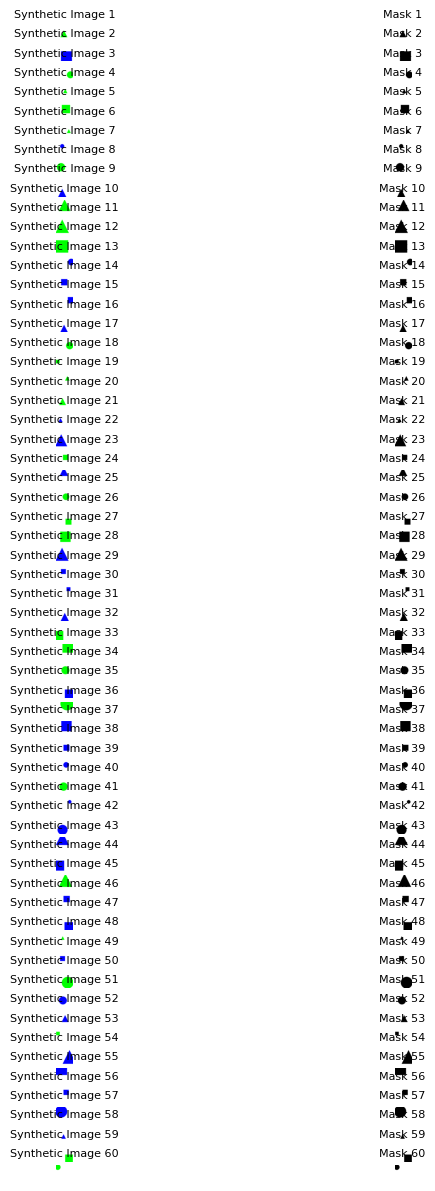

In [67]:
fig, axs = plt.subplots(num_images, 2, figsize=(8, 15))

axs = axs.flatten()

for i in range(num_images):
  
    image_path = os.path.join(dataset_dir, f'image_{i + 1}.png')
    img = Image.open(image_path)

  
    mask_path = os.path.join(masks_dir, f'mask_{i + 1}.png')
    mask = Image.open(mask_path)


    axs[2*i].imshow(np.array(img))
    axs[2*i].axis('off')
    axs[2*i].set_title(f'Synthetic Image {i + 1}', fontsize=8)

   
    axs[2*i + 1].imshow(np.array(mask), cmap='gray')  # Display in grayscale
    axs[2*i + 1].axis('off')
    axs[2*i + 1].set_title(f'Mask {i + 1}', fontsize=8)

plt.tight_layout()
plt.show()


In [68]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Trainging the Model using Data Set

The provided code builds and trains a convolutional neural network (CNN) for image segmentation using synthetic images and masks. The model architecture consists of an encoder-decoder structure with convolutional layers for feature extraction and upsampling layers for image reconstruction. The network comprises encoder and decoder sections. The encoder extracts features with convolutional layers and max-pooling. The decoder reconstructs masks using up-sampling and concatenation layers. A sigmoid-activated convolutional layer generates binary masks for segmentation. The model is trained for 10 epochs using the Adam optimizer and binary crossentropy loss. It achieves segmentation by outputting binary masks through a sigmoid activation function. The trained model is saved for future use.

In [69]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras import layers, models

dataset_dir = 'synthetic_dataset'
masks_dir = 'synthetic_masks'
image_filenames = os.listdir(dataset_dir)
images = []
masks = []

for filename in image_filenames:
    if filename.endswith('.png'):
        image_path = os.path.join(dataset_dir, filename)
        mask_path = os.path.join(masks_dir, 'mask_' + filename.split('_')[1])  

        image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
        image = tf.keras.preprocessing.image.img_to_array(image) / 255.0  
        images.append(image)

        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(128, 128), color_mode='grayscale')
        mask = tf.keras.preprocessing.image.img_to_array(mask) / 255.0  
        masks.append(mask)

images = np.array(images)
masks = np.array(masks)

split_ratio = 0.8
split_index = int(len(images) * split_ratio)

train_images, val_images = images[:split_index], images[split_index:]
train_masks, val_masks = masks[:split_index], masks[split_index:]

def build_model():
    inputs = layers.Input(shape=(128, 128, 3))
    
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    up1 = layers.UpSampling2D((2, 2))(conv3)

    merge1 = layers.concatenate([conv2, up1], axis=-1)
    conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge1)
    conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    up2 = layers.UpSampling2D((2, 2))(conv4)

    merge2 = layers.concatenate([conv1, up2], axis=-1)
    conv5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(merge2)
    conv5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv5)  # Output mask
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

model = build_model()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_images, train_masks, epochs=10, batch_size=32, validation_data=(val_images, val_masks))

model.save('segmentation_model.h5')

Epoch 1/10
2/2 [==============================] - 4s 1s/step - loss: 0.6793 - accuracy: 0.4473 - val_loss: 0.5694 - val_accuracy: 0.8634
Epoch 2/10
2/2 [==============================] - 2s 910ms/step - loss: 0.5320 - accuracy: 0.8300 - val_loss: 0.2726 - val_accuracy: 0.8502
Epoch 3/10
2/2 [==============================] - 2s 975ms/step - loss: 0.3282 - accuracy: 0.8190 - val_loss: 0.2310 - val_accuracy: 0.8502
Epoch 4/10
2/2 [==============================] - 2s 839ms/step - loss: 0.2625 - accuracy: 0.8315 - val_loss: 0.2005 - val_accuracy: 0.9560
Epoch 5/10
2/2 [==============================] - 2s 909ms/step - loss: 0.1972 - accuracy: 0.9556 - val_loss: 0.1247 - val_accuracy: 0.9643
Epoch 6/10
2/2 [==============================] - 2s 895ms/step - loss: 0.1309 - accuracy: 0.9637 - val_loss: 0.0804 - val_accuracy: 0.9825
Epoch 7/10
2/2 [==============================] - 2s 816ms/step - loss: 0.0710 - accuracy: 0.9840 - val_loss: 0.0387 - val_accuracy: 0.9912
Epoch 8/10
2/2 [=======

## Validation metrics on the Training Dataset

In [70]:
model = tf.keras.models.load_model('segmentation_model.h5')

test_loss, test_accuracy = model.evaluate(val_images, val_masks)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1/1 [==============================] - 0s 290ms/step - loss: 0.0165 - accuracy: 0.9950
Test Loss: 0.01651146449148655
Test Accuracy: 0.995025634765625


## Final Output

1/1 [==============================] - 0s 157ms/step


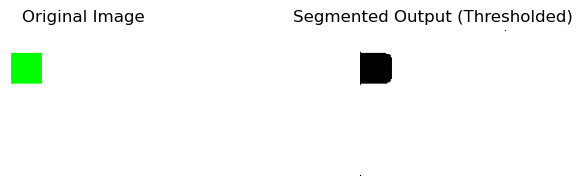

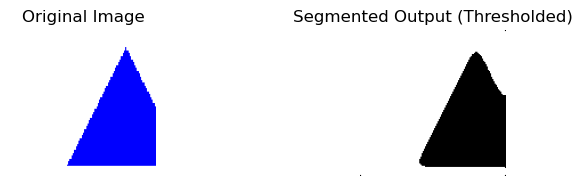

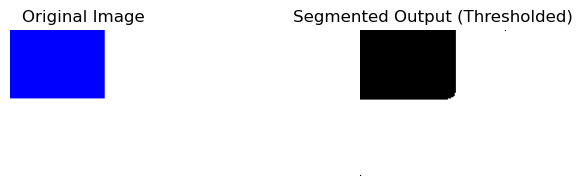

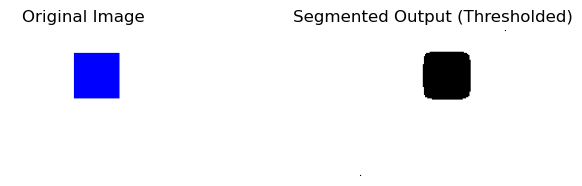

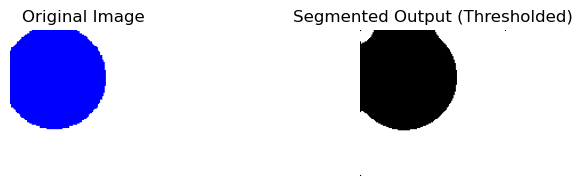

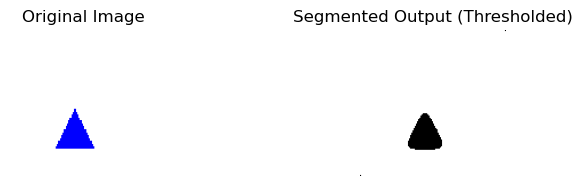

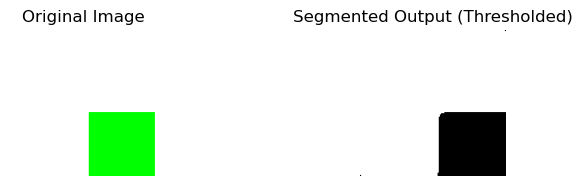

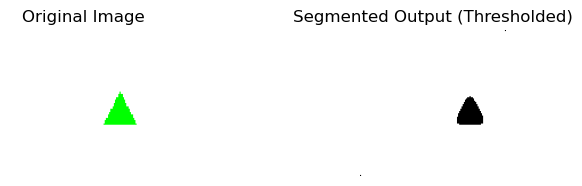

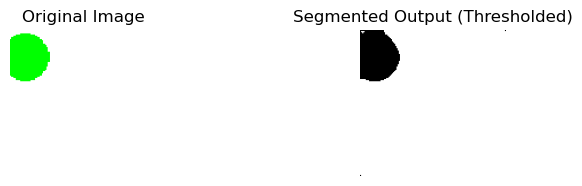

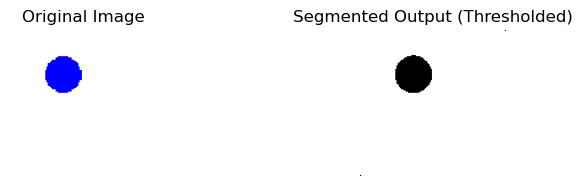

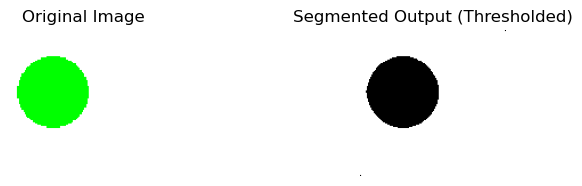

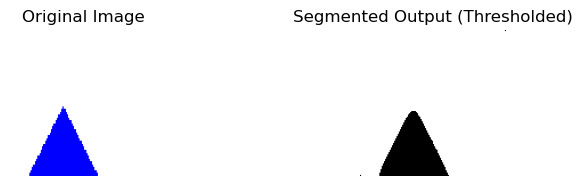

In [74]:
predicted_masks_1 = model.predict(val_images)

threshold = 0.85
thresholded_masks_1 = (predicted_masks_1 > threshold).astype(np.uint8)

for i in range(len(val_images)):
    plt.figure()
    
    plt.subplot(1, 3, 1)
    plt.imshow(val_images[i])
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(thresholded_masks_1[i][:, :, 0], cmap='gray')
    plt.title('Segmented Output (Thresholded)')
    plt.axis('off')
    
    plt.show()